In [1]:
# Code credit - partially based on https://github.com/gsurma/cartpole/blob/master/cartpole.py
import random
import gym
import gym_sdwan
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

import csv

import logging 
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.WARNING) 

import matplotlib.pyplot as plt 
%matplotlib inline


Using TensorFlow backend.
/home/controller/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/controller/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/controller/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/controller/.local/lib/python3.6/site-packages/t

In [3]:
pwd

'/home/controller/Documents/CodeRoom/deeproute-gym/tests'

In [3]:
ENV_NAME = "Sdwan-v0"

GAMMA = 0.95
LEARNING_RATE = 0.001

MEMORY_SIZE = 1000000
BATCH_SIZE = 20

EXPLORATION_MAX = 1.0
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.995

In [4]:
class DQNSolver:

    def __init__(self, observation_space, action_space):
        self.exploration_rate = EXPLORATION_MAX

        self.action_space = action_space
        self.memory = deque(maxlen=MEMORY_SIZE)

        self.model = Sequential()
        self.model.add(Dense(24, input_shape=(observation_space,), activation="relu"))
        self.model.add(Dense(24, activation="relu"))
        self.model.add(Dense(self.action_space, activation="linear"))
        self.model.compile(loss="mse", optimizer=Adam(lr=LEARNING_RATE))

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() < self.exploration_rate:
            action = random.randrange(self.action_space)
            print ("Taking random action", action)
            return action
        q_values = self.model.predict(state)
        action = np.argmax(q_values[0])
        print ("Taking predicted  action", action)
        return action

    def experience_replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        batch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, state_next, terminal in batch:
            q_update = reward
            if not terminal:
                q_update = (reward + GAMMA * np.amax(self.model.predict(state_next)[0]))
            q_values = self.model.predict(state)
            q_values[0][action] = q_update
            self.model.fit(state, q_values, verbose=0)
        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)


In [5]:
pwd

'/home/controller/Documents/CodeRoom/deeproute-gym/tests'

In [6]:
env = gym.make(ENV_NAME)
#score_logger = ScoreLogger(ENV_NAME)
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n
dqn_solver = DQNSolver(observation_space, action_space)
run = 0
score = 0
MAX_RUN = 3
score_card = []
while run < MAX_RUN:
    run += 1
    state = env.reset()
    state = np.reshape(state, [1, observation_space])
    step = 0
    while True:
        step += 1
        #env.render()
        action = dqn_solver.act(state)
        state_next, reward, terminal, info = env.step(action)
        #reward = reward if not terminal else -reward
        state_next = np.reshape(state_next, [1, observation_space])
        score += reward
        dqn_solver.remember(state, action, reward, state_next, terminal)
        state = state_next
        if terminal:
            print ("Run: " + str(run) + ", exploration: " + str(dqn_solver.exploration_rate) + ", score: " + str(score))
            score_card.append((run, score))
            break
        dqn_solver.experience_replay()

ValueError: Unable to configure handler 'info_file_handler': [Errno 13] Permission denied: '/home/controller/Documents/CodeRoom/deeproute-gym/tests/sdwan.info.log'

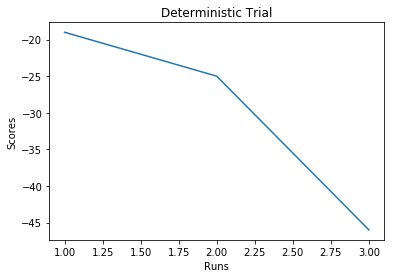

In [17]:


def draw_graph(data, title):
    # x axis values 
    x =   [x[0] for x in data]
    #print (x)
    # corresponding y axis values 
    y =  [x[1] for x in data]
    #print (y)

    # plotting the points  
    plt.plot(x, y) 
    


    # naming the x axis 
    plt.xlabel('Runs') 
    # naming the y axis 
    plt.ylabel('Scores') 

    # giving a title to my graph 
    plt.title(title) 

    # show a legend on the plot 
    #plt.legend() 

    # function to show the plot 
    plt.show() 

draw_graph(score_card, 'Deterministic Trial')

In [ ]:
with open('dqn_score_card.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(score_card)


In [3]:
# import csv
# with open('score_card.csv', 'r') as readFile:
#     reader = csv.reader(readFile)
#     lines = list(reader)
#     print(lines)


[['1', '-8'], ['2', '-26'], ['3', '-43']]


In [ ]:
env.cleanup()